## Model for Markov structure

In [6]:
import AssortmentGenerator as AG
import MarkovGenerator as MG
import Models

import numpy as np
import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt


N_prod = 10        # number of products
Vec_Len = N_prod + 1
Neck_Len = 5       # bottle neck width
EPOCHS = 1000
SAMPLE_AMOUNT = 10000
BATCH_SIZE = 500
TRAIN_VALI_RATE = 0.9
ADAM_LR = 0.005

# generate latent parameters
transP = MG.GenMarkovM(
    product_num = N_prod,
    gen_func = lambda x : MG.GenTransprob_Even(x)
)
lams = np.random.uniform(low = 0, high = 1, size = N_prod)
lams = lams / sum(lams)

# generate synthetic data
INPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
for i in range(SAMPLE_AMOUNT):
    # generate input vector, which has length vec_len
    # the first element is 0, which should be ignored when treated as an assortment
    assort = AG.GenAssortment_Even(N_prod)    
    INPUT[i] = AG.Product_0(assort)
    OUTPUT[i] = MG.Absorbing_Calculator(lams, transP, assort)

train_dataset = TensorDataset(torch.Tensor(INPUT[:int(SAMPLE_AMOUNT * TRAIN_VALI_RATE)]),torch.Tensor(OUTPUT[:int(SAMPLE_AMOUNT * TRAIN_VALI_RATE)]))    
vali_dataset = TensorDataset(torch.Tensor(INPUT[int(SAMPLE_AMOUNT * TRAIN_VALI_RATE):]),torch.Tensor(OUTPUT[int(SAMPLE_AMOUNT * TRAIN_VALI_RATE):]))    

train_loader = DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE)
vali_loader = DataLoader(vali_dataset, shuffle=True, batch_size = len(vali_dataset))

model = Models.MarkovStructure(Vec_Len)
optimizer = optim.Adam(model.parameters(), lr = ADAM_LR)
criterion = nn.BCELoss()

training_losses = []
vali_losses = []

for epo in range(1,EPOCHS+1):
    if epo % 50 == 0:
        print("epoch : ",epo)
    for step, (IN, TEST) in enumerate(train_loader):
        
        OUT = model(IN)
        loss = criterion(OUT,TEST)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_losses.append(loss.detach().item())
        
    for step, (VALI_IN, VALI_TEST) in enumerate(vali_loader):
        VALI_OUT = model(VALI_IN)
        loss = criterion(VALI_OUT,VALI_TEST)

        vali_losses.append(loss.detach().item())


np.save('EXP3_dump/MarkovStructure_train_loss', training_losses)
np.save('EXP3_dump/MarkovStructure_vali_loss', vali_losses)
torch.save(model, "EXP3_dump/MarkovStructure_model.pth")

epoch :  50
epoch :  100
epoch :  150
epoch :  200
epoch :  250
epoch :  300
epoch :  350
epoch :  400
epoch :  450
epoch :  500
epoch :  550
epoch :  600
epoch :  650
epoch :  700
epoch :  750
epoch :  800
epoch :  850
epoch :  900
epoch :  950
epoch :  1000


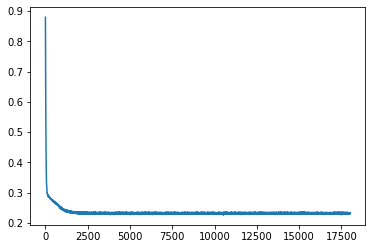

In [7]:
train_loss = np.load('EXP3_dump/MarkovStructure_train_loss.npy')
plt.plot(train_loss)

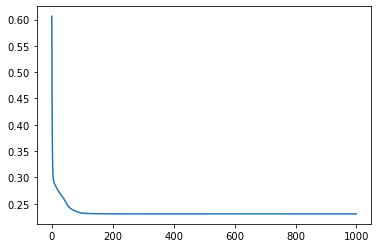

In [8]:
vali_loss = np.load('EXP3_dump/MarkovStructure_vali_loss.npy')
plt.plot(vali_loss)

## this structure learns really fast, cause it is specially designed for Markov. Next time test large product amount